In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


## Loading Data

In [68]:
df_sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e11/sample_submission.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")
df_train = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")

## EDA

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


## Clean Categorical Data into Numerical for Model

In [69]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['gender','marital_status','education_level','employment_status','loan_purpose','grade_subgrade']

def CLabeler(X,categorical_cols):
    encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        encoders[col] = le  # Save encoder if you need to transform test data or reverse later

CLabeler(df_train,categorical_cols)
CLabeler(df_test,categorical_cols)

## Data Visualization 

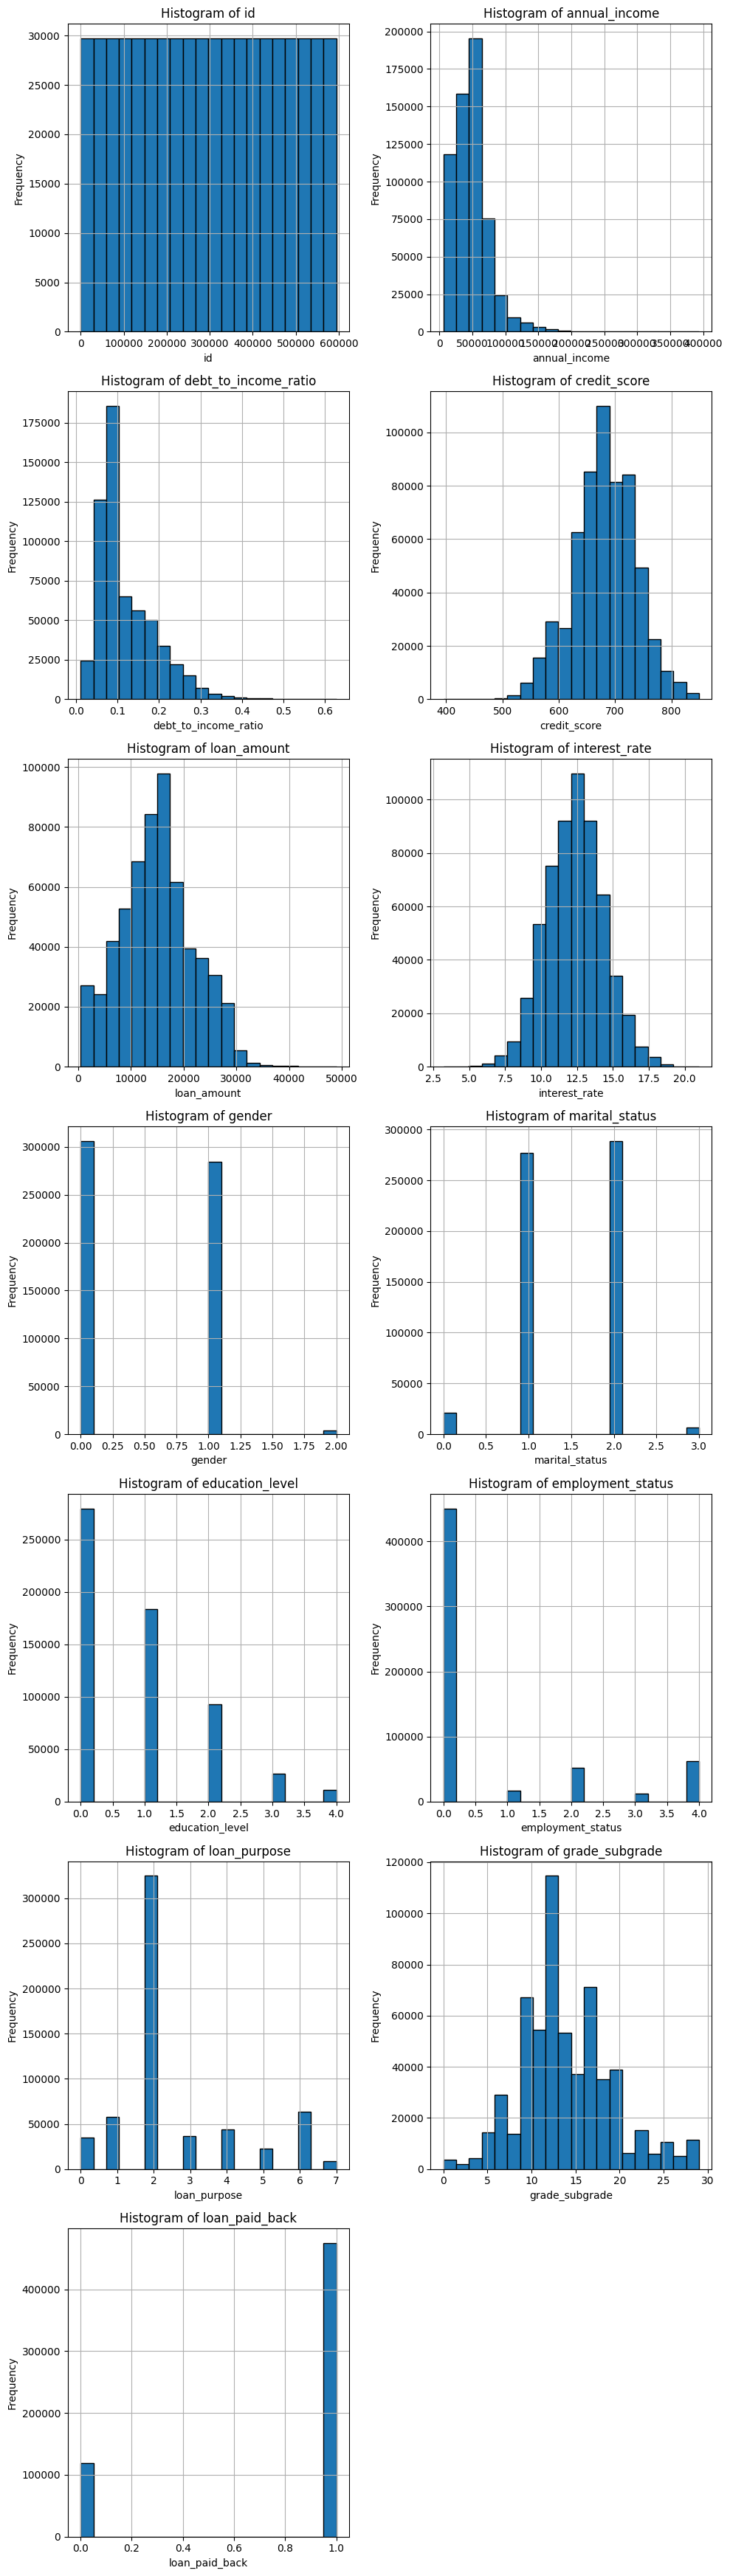

In [45]:
# Select only numerical columns for plotting histograms
numerical_cols = df_train.select_dtypes(include=np.number).columns

# Create a figure and a set of subplots
# You can adjust the layout (nrows, ncols) and figsize as needed
n_cols = len(numerical_cols)
n_rows = (n_cols + 1) // 2  # Adjust for a 2-column layout, or set explicitly
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(10, 5 * n_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Loop through each numerical column and plot a histogram
for i, col in enumerate(numerical_cols):
    ax = axes[i] # Get the current subplot axis
    df_train[col].hist(ax=ax, bins=20, edgecolor='black') # Plot histogram on the current axis
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Hide any unused subplots if the number of columns is not a perfect fit for the grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

In [81]:
from scipy.stats import yeojohnson

def Buckets(X):
        for base_col, new_col in [
            ("credit_score", "credit_bucket"),
            ("annual_income", "income_bucket"),
            ("debt_to_income_ratio", "dti_bucket")
        ]:
            try:
                X[new_col] = pd.qcut(
                    X[base_col],
                    5,
                    labels=False,
                    duplicates="drop"
                )
            except Exception as e:
                print(f"Bucket creation failed for {base_col}: {e}")
                X[new_col] = 0

def Feature_engineering(X):
    X['loan_to_income'] = X['loan_amount'] / X['annual_income']
    X['income_to_loan'] = X['annual_income'] / X['loan_amount']
    X['interest_loan'] = X['interest_rate'] * X['loan_amount']
    X['interest_credit'] = X['interest_rate'] * X['credit_score']
    

Feature_engineering(df_train)
Feature_engineering(df_test)
Buckets(df_train)
Buckets(df_test)

In [22]:
New_cat = ['credit_score_bucket']

CLabeler(df_train,New_cat)
CLabeler(df_test,New_cat)

## Correlation of variables

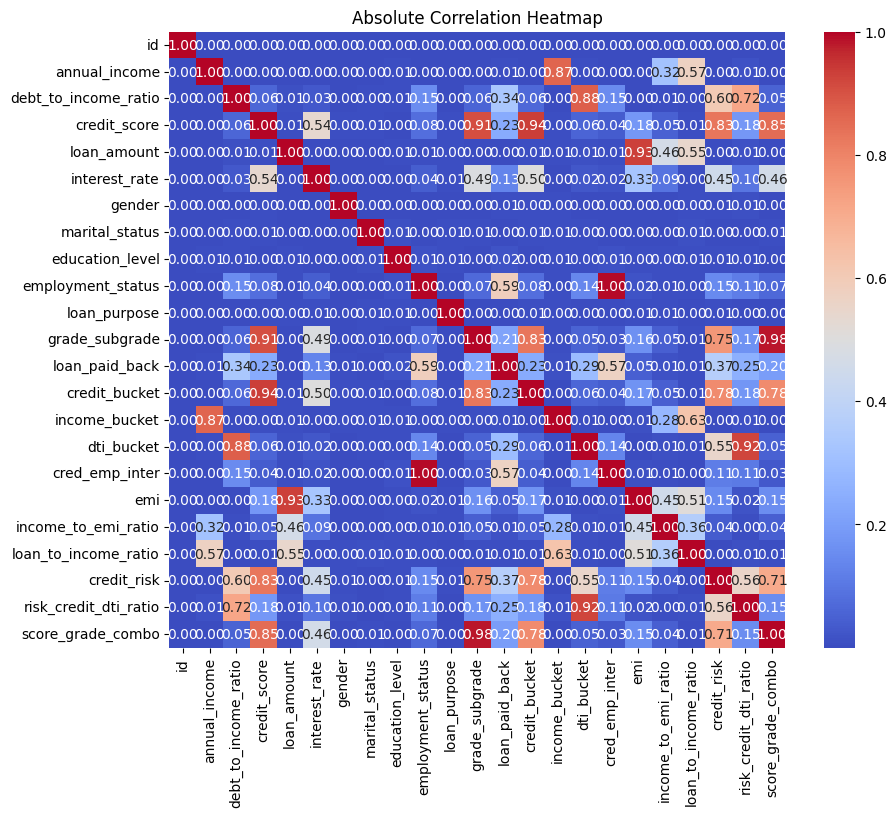

In [77]:
df_train.corr().abs().unstack().sort_values(ascending=False)
import seaborn as sns
import matplotlib.pyplot as plt

# Compute absolute correlation matrix
corr_matrix = df_train.corr().abs()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Absolute Correlation Heatmap")
plt.show()

## Find out best parameters for model

In [35]:
drop_col = ['id','grade_subgrade']
target = ['loan_paid_back']

X_train = df_train.drop(columns=drop_col + target)  
X_test = df_test.drop(columns=drop_col)
y_train = df_train['loan_paid_back']

In [66]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4,5,6],
    'learning_rate': [0.2,0.25],
    'n_estimators': [500,600],
    'subsample': [1.0],
    'reg_alpha': [1.0],
    'reg_lambda': [1.0]
}

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1  
)

grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best AUC score:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [21]:
X_test.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,loan_to_income,income_to_loan,interest_loan,interest_credit,log_annual_income,credit_score_bucket
0,28781.05,0.039119,626,11461.42,14.73,0,2,1,0,6,0.398228,2.511124,168826.7166,9220.98,10.267507,fair
1,46626.39,0.061883,732,15492.25,12.85,0,1,2,0,6,0.332264,3.009659,199075.4125,9406.20,10.749943,good
2,54954.89,0.107229,611,3796.41,13.29,1,2,0,0,2,0.069082,14.475489,50454.2889,8120.19,10.914286,fair
3,25644.63,0.068537,671,6574.30,9.57,0,2,0,0,2,0.256362,3.900739,62916.0510,6421.47,10.152128,good
4,25169.64,0.056544,688,17696.89,12.80,0,1,4,0,0,0.703105,1.422263,226520.1920,8806.40,10.133434,good


## Model Train and Predict

In [79]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier

# Define the model
model = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=1200,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric="auc"
)

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use cross_val_score with StratifiedKFold
scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')

print("Fold AUCs:", scores)
print("Mean AUC:", scores.mean())

# Fit on full training data (after CV) for final Kaggle submission
model.fit(X, y, 
         eval_set=[(X_val, y_val)],
         early_stopping_rounds=50,
         verbose=True)
y_test_pred = model.predict_proba(X_test)[:, 1]

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 1500, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [22:16:08] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x7badc3811fba]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x40645c) [0x7badc382845c]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x4071c5) [0x7badc38291c5]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x7badc3818316]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x7badc381a858]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x7badc37c4a07]
  [bt] (6) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x7badc3587c40]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7bae48752e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7bae4874f493]



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 1500, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [22:16:09] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x7badc3811fba]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x40645c) [0x7badc382845c]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x4071c5) [0x7badc38291c5]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x7badc3818316]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x7badc381a858]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x7badc37c4a07]
  [bt] (6) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x7badc3587c40]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7bae48752e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7bae4874f493]



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 1500, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [22:16:10] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x7badc3811fba]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x40645c) [0x7badc382845c]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x4071c5) [0x7badc38291c5]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x7badc3818316]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x7badc381a858]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x7badc37c4a07]
  [bt] (6) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x7badc3587c40]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7bae48752e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7bae4874f493]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 1500, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [22:16:11] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x7badc3811fba]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x40645c) [0x7badc382845c]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x4071c5) [0x7badc38291c5]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x7badc3818316]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x7badc381a858]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x7badc37c4a07]
  [bt] (6) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x7badc3587c40]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7bae48752e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7bae4874f493]




In [55]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd

# Drop ID and target columns
drop_col = ['id','grade_subgrade']
target = 'loan_paid_back'

X = df_train.drop(columns=drop_col + [target])
y = df_train[target]
X_test = df_test.drop(columns=drop_col)

# Define the model
clf = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    num_leaves=35,
    learning_rate=0.04799514605781845,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    scale_pos_weight=3.9706589958158998,
    bagging_freq=5,
    n_estimators=2425,
    verbose=-1
)

# StratifiedKFold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
scores = cross_val_score(clf, X, y, cv=skf, scoring='roc_auc')
print("Fold AUCs:", scores)
print("Mean AUC:", scores.mean())

# Fit on full training data (after CV) for final Kaggle submission
clf.fit(X, y, eval_metric="auc")
y_test_pred = clf.predict_proba(X_test)[:, 1]

# Build submission DataFrame
submission = pd.DataFrame({
    "id": df_test["id"],        # Kaggle usually requires the test IDs
    "loan_paid_back": y_test_pred  # or whatever the competition specifies
})

submission.to_csv("submission_lgb.csv", index=False)

Fold AUCs: [0.92206478 0.92200867 0.92005823 0.92167236 0.92067388]
Mean AUC: 0.9212955838939039


KeyboardInterrupt: 

In [ ]:
print(y_test_pred)

In [64]:
# Build submission
submission = pd.DataFrame({
    'id': df_test['id'],
    'loan_paid_back': y_test_pred
})

submission.to_csv('submission_xgb3.csv', index=False)

## Model differences

In [42]:
X = df_train.drop(columns=['loan_paid_back', 'id', 'grade_subgrade']) 
y = df_train['loan_paid_back'] 
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y )

In [ ]:
print(y_pred)

## Export Data for Submission

In [73]:
submission = pd.DataFrame({
    'id': df_test['id'],
    'loan_paid_back': y_prob
})

submission.to_csv('submissionxgb.csv', index=False)

In [67]:
df_sample_submission.shape

(254569, 2)